# Advanced matplotlib

Be sure to check out [`Intro_to_matplotlib.ipynb`](./Intro_to_matplotlib.ipynb) first!

In [1]:
import numpy as np
import matplotlib.pyplot as plt

Let's get some well data to play with.

In [3]:
from welly import Well

well = Well.from_las('https://geocomp.s3.amazonaws.com/data/B-41.las', index='original')

In [4]:
dt = well.data['DT'].values
depth = well.data['RHOB'].basis

rhob = well.data['RHOB'].values

## Seaborn... KDE plots, better scatters, and more

Unfortunately, there's no density plot built into `matplotlib`, but the plotting library `seaborn` does have one. (So does `pandas`.)

Let's look again at [distributions using `seaborn`](https://seaborn.pydata.org/tutorial/distributions.html).

In [4]:
dtn = dt[~np.isnan(dt)]

<AxesSubplot:ylabel='Density'>

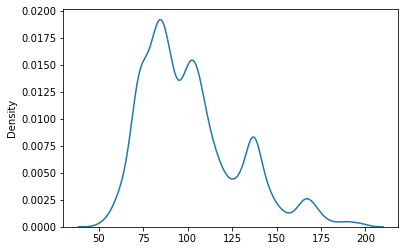

In [5]:
import seaborn as sns

sns.kdeplot(dtn, )

We can change the bandwidth of the Gaussian; the `bw_method` parameter is passed to [`scipy.stats.gaussian_kde'](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.gaussian_kde.html). 

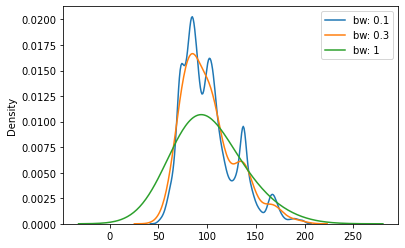

In [15]:
sns.kdeplot(dtn, bw_method=0.1, label="bw: 0.1")
sns.kdeplot(dtn, bw_method=0.3, label="bw: 0.3")
sns.kdeplot(dtn, bw_method=1, label="bw: 1")
plt.legend()

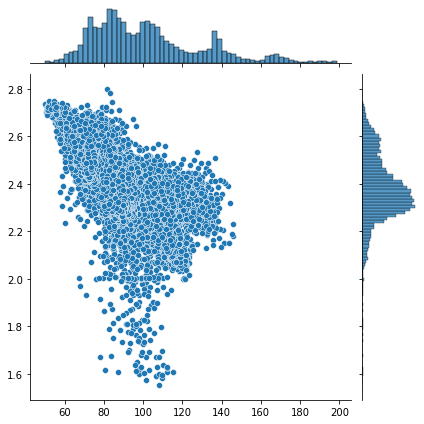

In [21]:
sns.jointplot(x=dt, y=rhob)

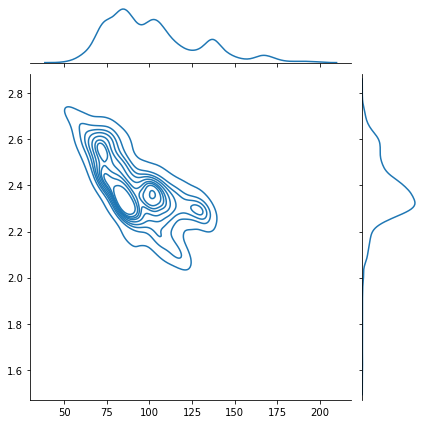

In [22]:
sns.jointplot(x=dt, y=rhob, kind='kde')

## The other way to plot rasters: `pcolormesh()`

Sometimes you might have varying cell sizes or shapes, or want to render the edges of the cells. Then you can use `pcolormesh()`. 

Read these articles to help figure out when to use what:

- http://thomas-cokelaer.info/blog/2014/05/matplotlib-difference-between-pcolor-pcolormesh-and-imshow/
- https://stackoverflow.com/questions/21166679/when-to-use-imshow-over-pcolormesh

Let's load some seismic data from a SEG-Y file.

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import segyio

ds = np.DataSource('../data')  # <- Local target.

url = 'https://geocomp.s3.amazonaws.com/data/Penobscot_0-1000ms.sgy'

with segyio.open(ds.open(url).name) as s:
    vol = segyio.cube(s)

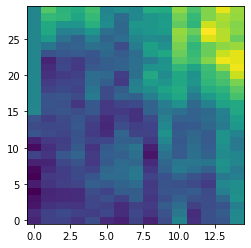

In [4]:
subset = vol[:30, :15, 100]

plt.imshow(subset, aspect=0.5, origin='lower')

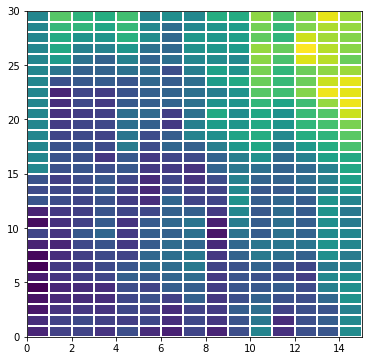

In [42]:
plt.figure(figsize=(6, 6))
plt.pcolormesh(subset, edgecolors=['white'], lw=1)
plt.show()

## Wiggle plot

Wiggle plots aren't really a thing outside seismology, so there's nothing built in to matplotlib to handle it. 

The main complexity comes from the fact that the trace is likely undersampled:

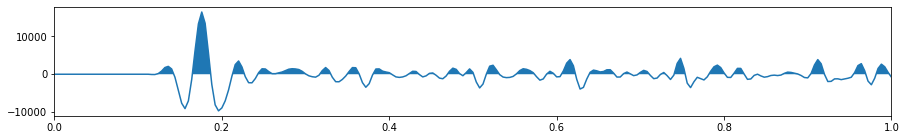

In [5]:
trace = vol[100, 100]
t = np.arange(0, 1.004, 0.004)

# Make an ugly wiggle plot.
plt.figure(figsize=(15, 2))
plt.plot(t, trace)
plt.fill_between(t, trace, where=trace>0, lw=2, interpolate=True)
#                                               ^^^^^^^^^^^^^^^^ to fill area under curve
plt.xlim(0, 1.0)
plt.show()

We can make a smoother curve with some resampling, using `scipy.interpolate.interp1d`:

    from scipy.interpolate import interp1d

    f = interp1d(t, trace, kind='cubic')
    t = np.arange(0, 1.00, 0.001)
    trace = f(t)

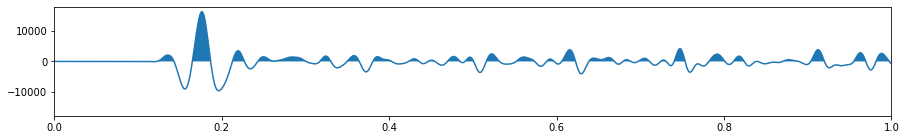

In [6]:
from scipy.interpolate import interp1d

f = interp1d(t, trace, kind='cubic')
t = np.arange(0, 1.00, 0.001)
trace = f(t)

plt.figure(figsize=(15, 2))
plt.plot(t, trace)
plt.fill_between(t, trace, where=trace>0, lw=2, interpolate=True)
plt.ylim(-18_000, 18_000)
plt.xlim(0, 1.0)
plt.show()

[Here's a function](https://gist.github.com/kwinkunks/f594b243e582666b5a808520e9add262) to help you plot a wiggle plot for a 2D seismic section. Call it like: 

    from wiggle import wiggle_2d
    
    t = np.arange(0, 1.004, 0.004)
    wiggle_2d(vol[100], time=t, gain=2)

## Interactive plots

There are a few ways to achieve interactivity. Here's a quick example:

In [1]:
import numpy as np
from ipywidgets import interact

ma = np.percentile(vol, 98)

@interact(t=(0, 251, 10))
def show(t):
    plt.imshow(vol[:, :, t], vmin=-ma, vmax=ma, aspect=0.5)
    plt.colorbar(shrink=0.75)
    plt.show()

NameError: name 'vol' is not defined

### Exercise

Can you make an interactive widget to add two numbers and print the result? 

In [52]:
@interact(a=(-10, 10, 1), b=(-10, 10, 1))
def add(a, b):
    print(a + b)

interactive(children=(IntSlider(value=0, description='a', max=10, min=-10), IntSlider(value=0, description='b'…

### Exercise

Can you make an interactive widget to plot a wavelet with various frequencies?

Start with with the following:

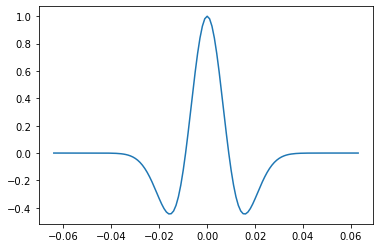

In [53]:
from bruges.filters import ricker

w, t = ricker(0.128, 0.001, f=25, return_t=True)
plt.plot(t, w)
plt.show()

In [54]:
import bruges as bg

@interact(f=(5, 75, 5))
def plot(f):
    w, t = bg.filters.ricker(0.128, 0.001, f, return_t=True)
    plt.plot(t, w)
    plt.show()

interactive(children=(IntSlider(value=40, description='f', max=75, min=5, step=5), Output()), _dom_classes=('w…

In [ ]:
wavelets = {'ricker': bg.filters.ricker,    # Very common.
            'berlage': bg.filters.berlage,  # Airgun signature (before zero-phasing).
            'klauder': bg.filters.klauder,  # Best for vibe.
            'sinc': bg.filters.sinc,
            'cosine': bg.filters.cosine,
            # It's hard to make the same widget work for Ormsby,
            # because it needs four frequencies.
           }

@interact(f=(8, 80, 2), wavelet=wavelets.keys())
def show(f, wavelet):
    if wavelet == 'klauder':
        f = (f/2, f*2)  # Bit of a hack.
    func = wavelets[wavelet]
    w, t = func(duration=0.128, dt=0.002, f=f, return_t=True, sym=True)
    plt.plot(t, w, color='red')
    plt.fill_between(t, w, where=w>0, interpolate=True, color='red')
    plt.ylim(-0.8, 1.1)
    plt.grid(c='k', alpha=0.2)